## TEXT PREPROCESSING

Notebook for processing articles (CORD-19 corpus) 


In [1]:
import pandas as pd                        
import numpy as np                         
import seaborn as sns                     
import matplotlib.pyplot as plt            
import re                                  
import string                              
import warnings                           
import nltk                                
from nltk.corpus import stopwords         
from gensim.corpora import Dictionary     

### Upload Kaggle dataset with abstracts + some filtering 

In [2]:
path = "sources/cord19/23_04_2022/metadata.csv"

In [3]:
pd.read_csv(path).head(3)

C:\Users\berl03\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [4]:
df_all = pd.read_csv(path)
df_all['Year'] = pd.DatetimeIndex(df_all['publish_time']).year
df_all['Month'] = pd.DatetimeIndex(df_all['publish_time']).month
df_all = df_all[["Year","Month","abstract","doi","cord_uid","journal","license","authors"]]
print("Number of all articles before cleaning and filtering (are duplicated across sources): "+str(len(df_all)))

df_all = df_all.drop_duplicates("doi")
print("Number of articles of unique doi :" + str(len(df_all)))

df_all = df_all[pd.notnull(df_all['abstract'])]
print("Number of articles of unique doi with not null abstracts:" + str(len(df_all)))

df_all['len'] =df_all['abstract'].map(len)
df_all = df_all[df_all['len']>10]
print("Number of articles of unique doi with len of abstract > 10:" + str(len(df_all)))

C:\Users\berl03\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of all articles before cleaning and filtering (are duplicated across sources): 992921
Number of articles of unique doi :598587
Number of articles of unique doi with not null abstracts:484124
Number of articles of unique doi with len of abstract > 10:483781


## Language detection

In [5]:
import fasttext

# Načtení předtrénovaného modelu pro detekci jazyka
model = fasttext.load_model('sources/lid.176.bin')  # stáhni model z https://fasttext.cc/docs/en/language-identification.html

def detector(text):
    result = model.predict(text, k=1)
    lang = result[0][0].split('__')[-1]  # Extrahuj jazyk z výstupu modelu
    return lang

In [6]:
df_all['language'] = df_all['abstract'].apply(detector)

In [7]:
df_all["language"].value_counts()

en     477237
fr       1465
es       1137
de       1080
id       1025
pt        845
nl        363
it        153
tr        123
zh        122
hu         77
ru         60
pl         28
sv          8
cs          8
he          6
hr          5
uk          5
ja          4
ca          3
no          3
ar          3
ro          3
sk          2
sl          2
ko          2
sr          2
fi          2
tl          1
ceb         1
el          1
ur          1
lt          1
da          1
az          1
bg          1
Name: language, dtype: int64

<AxesSubplot:>

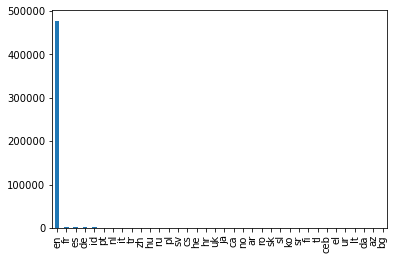

In [8]:
df_all["language"].value_counts().plot(kind="bar")

### Unfilter articles which are not english 

In [9]:
df_all = df_all[df_all["language"]=="en"]

In [10]:
len(df_all)

477237

#  TExt cleaning 


**Text cleaning steps**:
- Removed puctions except / and – (which are often used to connect words) / and – replaced with „“
- Converted to lower case
- Removed rare words (which are in less then 5 articles) 
- Removed some predefined stop words
- deleted single numbers (not of len = 4 – dont want to delte years)
- Lemmatization (convert the word into root word)

### Create functions for removing punctions, stopwords and lemmatization

In [11]:
def remove_punc_lower(text):   
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    # I dont want to remove dash, because dash is connection between words!
    remove = string.punctuation
    remove = remove.replace("-", "")     
    remove = remove.replace("/", "")
    pattern = r"[{}]".format(remove)
    text = re.sub(pattern, "", str(text).lower().strip())    
    return text

In [12]:
def remove_punc_from_list(string):
    punc = '''!()-[]{};:'"\, <>./?@#$%^&*_~'''
    for ele in string:  
        if ele in punc:  
            string = string.replace(ele, "") 
    return string

In [13]:
def lemm(text):
    lst_text = text.split()
    lem = nltk.stem.wordnet.WordNetLemmatizer()    
    lst_text = [lem.lemmatize(word) for word in lst_text]
    text = " ".join(lst_text)  
    return text

In [14]:
def delete_numbers(text):
    lst_text = text.split()
    lst_text = [word for word in lst_text if not (word.isdecimal()==True) & (len(word)!=4 ) ]
    text = " ".join(lst_text)
    return text

### Remove punction and convert to lower

In [15]:
%%time
df_all["abstract_cleaned"] = df_all["abstract"].astype(str).apply(lambda x: remove_punc_lower(x))

Wall time: 9.7 s


### Create list of removing words

In [16]:
%%time

corpus = df_all.abstract_cleaned.values

dataset = [d.split() for d in corpus]
dct = Dictionary(dataset)
print("Number of all words is :" + str(len(dct) ))
print("from original abstracts of number of articles: " + str(len(df_all)))

dct.filter_extremes(no_below=5)                 
print("Number of all words after removing rare words (contained below 5 articles) :" + str(len(dct) ))

# dont remove negative from stopwords (it can have importance)
stop_words = stopwords.words('english')
remove_from_stopwords = ["against","don't","no","not","aren't","didn't","doesn't","needn't","isn't","wasn't","weren't","wouldn't"]
stop_words = [ x for x in stop_words if x is not remove_from_stopwords]
stop_words.extend(["abstract","background","objective"])
stop_words = [remove_punc_from_list(i) for i in stop_words]

list_keep_words = list(dct.itervalues())
list_keep_words = list(set(list_keep_words) ^ set(stop_words))
print("Then after removing stopwords: "+ str(len(list_keep_words)))

list_removed_words = list(set(list(Dictionary(dataset).itervalues())) ^ set(list_keep_words))
list_removed_words.extend(stop_words)

Number of all words is :1124781
from original abstracts of number of articles: 477237
Number of all words after removing rare words (contained below 5 articles) :100000
Then after removing stopwords: 99907
Wall time: 3min 19s


In [17]:
len(list_removed_words)

1025092

In [18]:
%%time
cache = set(list_removed_words)
df_all["abstract_cleaned"]  = df_all['abstract_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in cache]))

Wall time: 20.8 s


### Lematizzer

In [19]:
%%time
df_all["abstract_cleaned"] = df_all["abstract_cleaned"].astype(str).apply(lambda x: lemm(x))

Wall time: 3min 30s


In [20]:
%%time
df_all["abstract_cleaned"]  = df_all['abstract_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in cache]))

Wall time: 12.8 s


### Delete numbers

In [21]:
df_all["abstract_cleaned"] = df_all["abstract_cleaned"].astype(str).apply(lambda x: delete_numbers(x))

### Some examples for checking:

In [22]:
print(df_all[['abstract',"abstract_cleaned"]][1:2].values)

[['Inflammatory diseases of the respiratory tract are commonly associated with elevated production of nitric oxide (NO•) and increased indices of NO• -dependent oxidative stress. Although NO• is known to have anti-microbial, anti-inflammatory and anti-oxidant properties, various lines of evidence support the contribution of NO• to lung injury in several disease models. On the basis of biochemical evidence, it is often presumed that such NO• -dependent oxidations are due to the formation of the oxidant peroxynitrite, although alternative mechanisms involving the phagocyte-derived heme proteins myeloperoxidase and eosinophil peroxidase might be operative during conditions of inflammation. Because of the overwhelming literature on NO• generation and activities in the respiratory tract, it would be beyond the scope of this commentary to review this area comprehensively. Instead, it focuses on recent evidence and concepts of the presumed contribution of NO• to inflammatory diseases of the l

In [23]:
print(df_all[['abstract',"abstract_cleaned"]][3:4].values)

[['Endothelin-1 (ET-1) is a 21 amino acid peptide with diverse biological activity that has been implicated in numerous diseases. ET-1 is a potent mitogen regulator of smooth muscle tone, and inflammatory mediator that may play a key role in diseases of the airways, pulmonary circulation, and inflammatory lung diseases, both acute and chronic. This review will focus on the biology of ET-1 and its role in lung disease.'
  'endothelin-1 et-1 amino acid peptide diverse biological activity implicated numerous disease et-1 potent mitogen regulator smooth muscle tone inflammatory mediator may play key role disease airway pulmonary circulation inflammatory lung disease acute chronic review focus biology et-1 role lung disease']]


In [24]:
print(df_all[['abstract',"abstract_cleaned"]][9:10].values)

[['This report describes the design and implementation of the Real-time Outbreak and Disease Surveillance (RODS) system, a computer-based public health surveillance system for early detection of disease outbreaks. Hospitals send RODS data from clinical encounters over virtual private networks and leased lines using the Health Level 7 (HL7) message protocol. The data are sent in real time. RODS automatically classifies the registration chief complaint from the visit into one of seven syndrome categories using Bayesian classifiers. It stores the data in a relational database, aggregates the data for analysis using data warehousing techniques, applies univariate and multivariate statistical detection algorithms to the data, and alerts users of when the algorithms identify anomalous patterns in the syndrome counts. RODS also has a Web-based user interface that supports temporal and spatial analyses. RODS processes sales of over-the-counter health care products in a similar manner but recei

In [25]:
print(df_all[['abstract',"abstract_cleaned"]][21:22].values)

[['Horizontal DNA transfer is an important factor of evolution and participates in biological diversity. Unfortunately, the location and length of horizontal transfers (HTs) are known for very few species. The usage of short oligonucleotides in a sequence (the so-called genomic signature) has been shown to be species-specific even in DNA fragments as short as 1 kb. The genomic signature is therefore proposed as a tool to detect HTs. Since DNA transfers originate from species with a signature different from those of the recipient species, the analysis of local variations of signature along recipient genome may allow for detecting exogenous DNA. The strategy consists in (i) scanning the genome with a sliding window, and calculating the corresponding local signature (ii) evaluating its deviation from the signature of the whole genome and (iii) looking for similar signatures in a database of genomic signatures. A total of 22 prokaryote genomes are analyzed in this way. It has been observed

In [26]:
corpus = df_all.abstract_cleaned.values
dataset = [d.split() for d in corpus]
dct = Dictionary(dataset)
print("Number of words after cleaning: "+str(len(dct)))

Number of words after cleaning: 91229


# FInal export

In [27]:
df_all['len'] = df_all['abstract_cleaned'].astype(str).map(len)
df_final_cleaned = df_all[df_all['len']>20]

In [28]:
print("Number of articles of cleaned abstracts with len of abstract > 20:" + str(len(df_final_cleaned)))

Number of articles of cleaned abstracts with len of abstract > 20:476175


In [29]:
df_final_cleaned.to_csv("outputs/df_sw_tok_low_punc_lemm_v7.csv")

In [30]:
df_all = pd.read_csv("outputs/df_sw_tok_low_punc_lemm_v7.csv")

In [31]:
df_all

,Unnamed: 0,Year,Month,abstract,doi,cord_uid,journal,license,authors,len,language,abstract_cleaned
0,0,2001.0,7.0,OBJECTIVE: This retrospective chart review des...,10.1186/1471-2334-1-6,ug7v899j,BMC Infect Dis,no-cc,"Madani, Tariq A; Al-Ghamdi, Aisha A",1158,en,retrospective chart review describes epidemiol...
1,1,2000.0,8.0,Inflammatory diseases of the respiratory tract...,10.1186/rr14,02tnwd4m,Respir Res,no-cc,"Vliet, Albert van der; Eiserich, Jason P; Cros...",718,en,inflammatory disease respiratory tract commonl...
2,2,2000.0,8.0,Surfactant protein-D (SP-D) participates in th...,10.1186/rr19,ejv2xln0,Respir Res,no-cc,"Crouch, Erika C",1228,en,surfactant sp-d participates innate response i...
3,3,2001.0,2.0,Endothelin-1 (ET-1) is a 21 amino acid peptide...,10.1186/rr44,2b73a28n,Respir Res,no-cc,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",302,en,endothelin-1 et-1 amino acid peptide diverse b...
4,4,2001.0,5.0,Respiratory syncytial virus (RSV) and pneumoni...,10.1186/rr61,9785vg6d,Respir Res,no-cc,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",656,en,respiratory syncytial virus rsv pneumonia viru...
...,...,...,...,...,...,...,...,...,...,...,...,...
476170,992915,2020.0,8.0,"In the near future, the overlap of Coronavirus...",10.1590/0074-02760200225,wmolf5lk,Mem Inst Oswaldo Cruz,cc-by,"Spinicci, Michele; Bartoloni, Alessandro; Mant...",516,en,near future overlap coronavirus disease 2019 c...
476171,992916,2022.0,2.0,Community-based exercise programs for older ad...,10.1007/s40520-022-02079-y,dl1nyd1x,Aging Clin Exp Res,cc-by,"Fien, Samantha; Linton, Corey; Mitchell, Jules...",1276,en,community-based exercise program older adult p...
476172,992917,2020.0,10.0,BACKGROUND: Coronavirus disease 2019 (COVID-19...,10.1093/ckj/sfaa199,bxi27jib,Clin Kidney J,cc-by-nc,"Lano, Guillaume; Braconnier, Antoine; Bataille...",1120,en,coronavirus disease 2019 covid-19 emerging inf...
476173,992919,2020.0,3.0,We conducted a comparative study of COVID-19 e...,10.1101/2020.03.09.20033464,z7r45291,NaN,medrxiv,"Tang, Biao; Xia, Fan; Bragazzi, Nicola Luigi; ...",1234,en,conducted comparative study covid-19 epidemic ...
